In [1]:
import pandas as pd
valid = pd.read_csv('validation_data.csv')

In [2]:
valid.head()

,Headline,Body ID,Stance
0,Brain op shock as teen wakes up mid-surgery,400,unrelated
1,Islamic State puts James Foley’s body up for s...,934,unrelated
2,Argentina's President Didn’t Adopt A Jewish Ch...,897,agree
3,Scorpion stings woman on OSU plane,1297,agree
4,Justin Bieber ringtone saves man being mauled ...,2464,unrelated


In [8]:
a = ["agree"] * len(valid)

In [10]:
a_new = pd.Series(a)
valid["test"] = a_new.values

In [11]:
valid.head()

,Headline,Body ID,Stance,test
0,Brain op shock as teen wakes up mid-surgery,400,unrelated,agree
1,Islamic State puts James Foley’s body up for s...,934,unrelated,agree
2,Argentina's President Didn’t Adopt A Jewish Ch...,897,agree,agree
3,Scorpion stings woman on OSU plane,1297,agree,agree
4,Justin Bieber ringtone saves man being mauled ...,2464,unrelated,agree


In [13]:
import re
valid['test'] = valid['Headline'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [17]:
valid['test'] = [x.encode('ascii') for x in valid['test']]

In [23]:
from tokenize import tokenize
tokenizer = Tokenizer(nb_words=2500, lower=True,split=' ')
tokenizer.fit_on_texts(valid['test'].values)
#print(tokenizer.word_index)  # To see the dicstionary
X = tokenizer.texts_to_sequences(valid['test'].values)
X = pad_sequences(X)

TypeError: tokenize() got an unexpected keyword argument 'nb_words'

In [4]:
valid['class'] = valid['Stance'].map({'agree':0, 'disagree':1, 'discuss':2, 'unrelated':3})

## pre-processing 

In [7]:
valid['keywords_title'] = None
import nltk
from nltk.corpus import stopwords
import string 
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from tqdm import tqdm

for i in tqdm(range(0, len(valid))):
    result =[]
    userInput = valid['Headline'][i]
    table = str.maketrans({key: None for key in string.punctuation})
    new_userInput = userInput.translate(table)
    ps = PorterStemmer()
    
    tokens = nltk.word_tokenize(new_userInput.lower())
    stopset = set(stopwords.words('english'))
    for k in tokens:
        if k not in stopset:
            result.append(ps.stem(k))
    valid['keywords_title'][i] = result

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
valid.head()

,Headline,Body ID,Stance,class,keywords_title
0,Brain op shock as teen wakes up mid-surgery,400,unrelated,3,"[brain, op, shock, teen, wake, midsurgeri]"
1,Islamic State puts James Foley’s body up for s...,934,unrelated,3,"[islam, state, put, jame, foley, ’, bodi, sale..."
2,Argentina's President Didn’t Adopt A Jewish Ch...,897,agree,0,"[argentina, presid, ’, adopt, jewish, child, a..."
3,Scorpion stings woman on OSU plane,1297,agree,0,"[scorpion, sting, woman, osu, plane]"
4,Justin Bieber ringtone saves man being mauled ...,2464,unrelated,3,"[justin, bieber, rington, save, man, maul, bear]"


In [9]:
stopwords = ['’', '“', '—', '”', '–', '‘']
for i in range(0, len(valid)):
    words = valid['keywords_title'][i]
    for word in words:  # iterating on a copy since removing will mess things up
        if word in stopwords:
            words.remove(word)

In [11]:
bodies = pd.read_csv('article_body_texts_1.csv')

In [13]:
bodies = bodies.drop(['Unnamed: 0'], axis = 1)

In [14]:
bodies.head()

,Body ID,articleBody,keywords_article,body_sentiment
0,0,A small meteorite crashed into a wooded area i...,"['small', 'meteorit', 'crash', 'wood', 'area',...",0.009971
1,4,Last week we hinted at what was to come as Ebo...,"['last', 'week', 'hint', 'come', 'ebola', 'fea...",0.105579
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...,"['newser', 'wonder', 'long', 'quarter', 'pound...",0.176389
3,6,"Posting photos of a gun-toting child online, I...","['post', 'photo', 'guntot', 'child', 'onlin', ...",-0.010065
4,7,At least 25 suspected Boko Haram insurgents we...,"['least', '25', 'suspect', 'boko', 'haram', 'i...",-0.050966


In [15]:
valid = pd.merge(valid, bodies, on='Body ID')

## title_sentiment and article_sentiment

In [18]:
from textblob import TextBlob
from tqdm import tqdm
valid['title_sentiment'] = None

for i in tqdm(range(0, len(valid))):
    headline = TextBlob(valid['Headline'][i])
    valid['title_sentiment'][i] = headline.sentiment[0]

  0%|          | 0/2438 [00:00<?, ?it/s]/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
100%|██████████| 2438/2438 [01:29<00:00, 27.14it/s]


## unigram_ratio, bigram_ratio, trigram_ratio

In [21]:
import nltk
from nltk import bigrams
valid['bigram_ratio'] = None

In [25]:
from tqdm import tqdm
from ast import literal_eval
for i in tqdm(range(0, len(valid))):
    headline_bigrams = list(bigrams(valid['keywords_title'][i]))
    article_bigrams = list(bigrams(literal_eval(valid['keywords_article'][i])))
    res = [val for val in headline_bigrams if val in article_bigrams]
    valid['bigram_ratio'][i] = len(res) / len(headline_bigrams) if len(headline_bigrams) != 0 else 0

  0%|          | 0/2438 [00:00<?, ?it/s]/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
100%|██████████| 2438/2438 [01:32<00:00, 26.25it/s]


In [26]:
valid['unigram_ratio'] = None
valid['trigram_ratio'] = None

In [27]:
for i in tqdm(range(0, len(valid))):
    headline = valid['keywords_title'][i]
    article = literal_eval(valid['keywords_article'][i])
    res = [val for val in headline if val in article]
    valid['unigram_ratio'][i] = len(res) / len(headline) if len(headline) != 0 else 0

  0%|          | 0/2438 [00:00<?, ?it/s]/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
100%|██████████| 2438/2438 [01:29<00:00, 27.14it/s]


In [28]:
from nltk import trigrams
from tqdm import tqdm
from ast import literal_eval
for i in tqdm(range(0, len(valid))):
    headline_trigrams = list(trigrams(valid['keywords_title'][i]))
    article_trigrams = list(trigrams(literal_eval(valid['keywords_article'][i])))
    res = [val for val in headline_trigrams if val in article_trigrams]
    valid['trigram_ratio'][i] = len(res) / len(headline_trigrams) if len(headline_trigrams) != 0 else 0

  0%|          | 0/2438 [00:00<?, ?it/s]/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
100%|██████████| 2438/2438 [01:32<00:00, 26.30it/s]


In [31]:
valid.to_csv('validation_data_1.csv')

## google_similarity 

In [1]:
from gensim.models import KeyedVectors
filename = 'GoogleNews-vectors-negative300.bin'
model = KeyedVectors.load_word2vec_format(filename, binary=True)

In [7]:
#300 dimensions representation of the word
a = model.wv['computer']
b = model.wv['computation']

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
from sklearn.metrics.pairwise import cosine_similarity
result = cosine_similarity([a, b])

In [22]:
result

array([[ 1.        ,  0.29297638],
       [ 0.29297638,  1.        ]], dtype=float32)

In [ ]:
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
import string 

for i in tqdm(range(0, 100)):
    result = []
    userInput = data['Headline'][i]
    table = str.maketrans({key: None for key in string.punctuation})
    new_userInput = userInput.translate(table)
    
    tokens = nltk.word_tokenize(new_userInput.lower())
    stopset = set(stopwords.words('english'))
    for k in tokens:
        if k not in stopset:
            result.append(k)
        
    userInput_2 = data['articleBody'][i]
    new_userInput_2 = userInput_2.translate(table)
   
    result_2 = []
    tokens_2 = nltk.word_tokenize(new_userInput_2.lower())
    stopset = set(stopwords.words('english'))
    for k in tokens_2:
        if k not in stopset:
            result_2.append(k)
        
    w = list(filter(lambda x: x in model.vocab, result))
    w_2 = list(filter(lambda x: x in model.vocab, result_2))
    distance = model.wv.n_similarity(w, w_2)
    data['google_similarity'][i] = distance

## tfidf_similarity

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
TfidfVec = TfidfVectorizer(stop_words='english')

def cos_similarity(textlist):
    tfidf = TfidfVec.fit_transform(textlist)
    return (tfidf * tfidf.T).toarray()

for i in tqdm(range(0, 2)):
    d1 = valid['keywords_title'][i]
    str1 = ' '.join(d1)
    d2 = literal_eval(valid['keywords_article'][i])
    str2 = ' '.join(d2)
    documents = [str1, str2]
    
    res = cos_similarity(documents)
    valid['tfidf_similarity'][i] = res[1][0]

  0%|          | 0/2 [00:00<?, ?it/s]/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
100%|██████████| 2/2 [00:00<00:00, 22.64it/s]


In [39]:
valid.tail()

,Headline,Body ID,Stance,class,keywords_title,articleBody,keywords_article,body_sentiment,title_sentiment,bigram_ratio,unigram_ratio,trigram_ratio,tfidf_similarity
2433,Donald Trump walks back campaign pledges on an...,2554,discuss,2,"[donald, trump, walk, back, campaign, pledg, a...",Donald Trump’s intentions regarding US partici...,"['donald', 'trump', 'intent', 'regard', 'us', ...",0.016502,0,0.222222,0.6,0,0.14811
2434,Scoop: Trump tells confidants U.S. will quit P...,2554,discuss,2,"[scoop, trump, tell, confid, us, quit, pari, c...",Donald Trump’s intentions regarding US partici...,"['donald', 'trump', 'intent', 'regard', 'us', ...",0.016502,0,0.25,0.777778,0.142857,0.223725
2435,"For President Trump, Pulling Out Of Paris Is T...",2554,discuss,2,"[presid, trump, pull, pari, logic, move]",Donald Trump’s intentions regarding US partici...,"['donald', 'trump', 'intent', 'regard', 'us', ...",0.016502,0.125,0,0.666667,0,0.211456
2436,"IBM to cut more than 111,000 jobs in largest c...",943,discuss,2,"[ibm, cut, 111000, job, largest, corpor, layof...",IBM is expected to go through a massive reorg ...,"['ibm', 'expect', 'go', 'massiv', 'reorg', 'ne...",0.016427,0.25,0.428571,0.875,0.166667,0.269798
2437,IBM is about to get hit with a massive reorg a...,943,discuss,2,"[ibm, get, hit, massiv, reorg, layoff]",IBM is expected to go through a massive reorg ...,"['ibm', 'expect', 'go', 'massiv', 'reorg', 'ne...",0.016427,0,0.2,1,0,0.247861


## train the model 

In [40]:
training = pd.read_csv('full_stances.csv')
new_valid = valid[['body_sentiment', 'title_sentiment', 'unigram_ratio', 'bigram_ratio', 'trigram_ratio', 'tfidf_similarity']].copy()
new_training = training[['body_sentiment', 'title_sentiment', 'unigram_ratio', 'bigram_ratio', 'trigram_ratio', 'tfidf_similarity']].copy()


In [46]:
X_train = new_training
y_train = training['class'].values

X_test = new_valid
y_test = valid['class'].values

Text(0,0.5,'2nd principal component')

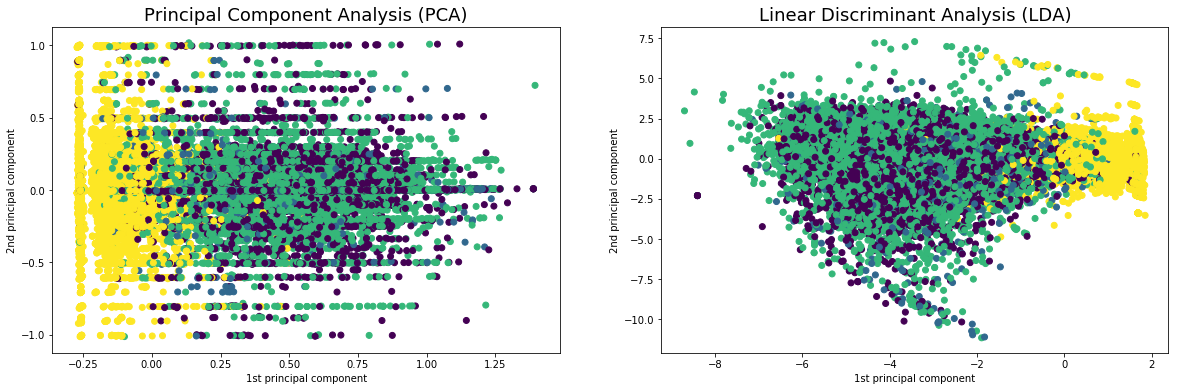

In [69]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
%matplotlib inline
import matplotlib.pyplot as plt

pca = PCA(n_components=5)
X_r = pca.fit(X_train, y_train).transform(X_train)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))# plotting images side by side
s_plot = ax1.scatter(x=X_r[:,0], y=X_r[:,1], c=y_train)
ax1.set_title('Principal Component Analysis (PCA)', fontsize=18)
ax1.set_xlabel('1st principal component')
ax1.set_ylabel('2nd principal component')

lda = LinearDiscriminantAnalysis(n_components=5)
X_r2 = lda.fit(X_train, y_train).transform(X_train)

s_plot = ax2.scatter(x=X_r2[:,0], y=X_r2[:,1], c=y_train)
ax2.set_title('Linear Discriminant Analysis (LDA)', fontsize=18)
ax2.set_xlabel('1st principal component')
ax2.set_ylabel('2nd principal component')

In [90]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5)
logreg.fit(X_train, y_train)
predict_result_logreg = logreg.predict(X_test)
print('Accuracy of Lasso classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Lasso classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))

Accuracy of Lasso classifier on training set: 0.88
Accuracy of Lasso classifier on test set: 0.88


In [91]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
predict_result_NB = gnb.predict(X_test)
print('Accuracy of Lasso classifier on training set: {:.2f}'
     .format(gnb.score(X_train, y_train)))
print('Accuracy of Lasso classifier on test set: {:.2f}'
     .format(gnb.score(X_test, y_test)))

Accuracy of Lasso classifier on training set: 0.87
Accuracy of Lasso classifier on test set: 0.87


In [92]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)
predict_result_SVM = clf.predict(X_test)
print('Accuracy of Lasso classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Lasso classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Lasso classifier on training set: 0.88
Accuracy of Lasso classifier on test set: 0.88


In [110]:
from collections import Counter
def get_accuracy(predict_result, y_test):
    count = 0
    for i in range(0, len(predict_result)):
        if predict_result[i] == y_test[i] and y_test[i] == 3:
            count += 0.25
        elif y_test[i] != 3:
            if predict_result[i] != 3:
                count += 0.25
                if predict_result[i] == y_test[i]:
                    count += 0.75
    a1 = Counter(y_test)
    total_score = a1[3] * 0.25 + (a1[0] + a1[1] + a1[2]) * 1
    accuracy = count / total_score
    return accuracy

weighted scores for Logistic Regression, Naive Bayes and SVM

In [130]:
get_accuracy(predict_result_logreg, y_test)

0.7864421798848028

In [131]:
get_accuracy(predict_result_NB, y_test)

0.7964111652636243

In [132]:
get_accuracy(predict_result_SVM, y_test)

0.8017279574656624